In [1]:
# pip install opencv-python

In [2]:
# pip install imageio

In [3]:
# pip install torchvision

In [4]:
# pip uninstall -y torchvision torch torchaudio

In [5]:
# pip install --no-cache-dir --index-url https://download.pytorch.org/whl/cpu torch torchvision torchaudio

In [6]:
# pip install seaborn

In [7]:
import os
import json
import os, glob, math, numpy as np, pandas as pd, cv2
import seaborn as sns
import torch.optim as optim
from pathlib import Path
from IPython.display import Video, display
import imageio.v2 as imageio
import cv2
from collections import Counter
from PIL import Image
import torch
import torch.nn as nn
from collections import Counter

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GroupShuffleSplit, GroupKFold, StratifiedGroupKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, auc, precision_recall_fscore_support, classification_report
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import (
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
)
from sklearn.neural_network import MLPClassifier

# try:
#     from xgboost import XGBClassifier
#     _HAS_XGB = True
# except Exception:
#     _HAS_XGB = False

# try:
#     from lightgbm import LGBMClassifier
#     _HAS_LGBM = True
# except Exception:
#     _HAS_LGBM = False

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import kagglehub
from kagglehub import KaggleDatasetAdapter

os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)

c:\Users\APC\miniconda3\envs\new\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


In [9]:
import gdown
def load_cleveland_data():
    gdown.download('https://drive.google.com/uc?id=16HPyuXWXPptt5g3xvS_kR_wXAfjpR1Ju', 'cleveland.csv', quiet=False)
    DATA_PATH = 'cleveland.csv'

    COLUMNS = ['age','sex','cp','trestbps','chol','fbs','restecg',
                'thalach','exang','oldpeak','slope','ca','thal','target']
    raw_df = pd.read_csv(DATA_PATH, header=None, names=COLUMNS)
    print(f"Cleverland data shape: {raw_df.shape}")
    print(raw_df.head())

    raw_df = raw_df.replace('?', np.nan)
    for col in raw_df.columns:
        if col != 'target':
            raw_df[col] = pd.to_numeric(raw_df[col], errors='coerce')

    raw_df['target'] = (raw_df['target'] > 0).astype(int)

    print(f"Target distribution: {raw_df['target'].value_counts()}")

    return raw_df

In [10]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "cardio_train.csv"

# Load the latest version
sulianova_data = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "sulianova/cardiovascular-disease-dataset",
    file_path,
    pandas_kwargs={"sep": ";", "names": ["id", "age", "gender", "height", "weight", "ap_hi", "ap_lo", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"]}
)

ValueError: Error reading file: 'utf-8' codec can't decode byte 0xf6 in position 10: invalid start byte

age_years = floor(age/365.25) --> tuổi (năm).

bmi = weight / (height(m)^2) --> chỉ số BMI.

pp = ap_hi - ap_lo --> pulse pressure (áp lực mạch).

map = ap_lo + pp/3 --> mean arterial pressure (huyết áp trung bình).

sbp_dbp_ratio = ap_hi / ap_lo.

is_hypertensive (≥140/90 mmHg)

prehypertensive (tiền tăng huyết áp 120–139/80–89),

wide_pp (pp ≥ 60).

chol_high = (chol ≥ 2),

gluc_high = (gluc ≥ 2).

risk_behaviors = smoke + alco + (1 - active) (tổng hành vi nguy cơ, hút thuốc, uống rượu và ít hoạt động).

age_bin: [<40, 40–49, 50–59, 60–69, ≥70] 

bmi_class: gầy/BT/thừa cân/béo phì --> nhãn 0–3 theo ngưỡng (18.5/25/30).

bp_category: SBP theo ngưỡng 120/130/140 --> nhãn 0–3.

bmi_x_age = bmi * age_years

pp_x_age = pp * age_years

htn_x_chol = is_hypertensive * chol_high

Dùng RobustScaler (median/IQR) cho:
age, age_years, height, weight, ap_hi, ap_lo, bmi, pp, map, sbp_dbp_ratio, bmi_x_age, pp_x_age

In [11]:
sulianova_data = pd.DataFrame(sulianova_data)
print('number of sample:', len(sulianova_data))
print("First 5 records:", sulianova_data.head())

number of sample: 70001
First 5 records:    id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0  id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke   
1   0  18393       2     168    62.0    110     80            1     1      0   
2   1  20228       1     156    85.0    140     90            3     1      0   
3   2  18857       1     165    64.0    130     70            3     1      0   
4   3  17623       2     169    82.0    150    100            1     1      0   

   alco  active  cardio  
0  alco  active  cardio  
1     0       1       0  
2     0       1       1  
3     0       0       1  
4     0       1       1  


## Load dataset

In [12]:
cleveland_data = load_cleveland_data()

print(f"Data after loading:")
cleveland_data.head()

Downloading...
From: https://drive.google.com/uc?id=16HPyuXWXPptt5g3xvS_kR_wXAfjpR1Ju
To: d:\CODE\AIO2025 - Main\Time-Series-Team-Hub\assets\feature_heartdisease_classification\cleveland.csv
100%|██████████| 10.9k/10.9k [00:00<00:00, 475kB/s]

Cleverland data shape: (303, 14)
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  target  
0  0.0   6.0       0  
1  3.0   3.0       2  
2  2.0   7.0       1  
3  0.0   3.0       0  
4  0.0   3.0       0  
Target distribution: target
0    164
1    139
Name: count, dtype: int64
Data after loading:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [13]:
cleveland_data.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

In [14]:
def load_echonet_with_kagglehub():
    """Load EchoNet-Dynamic dataset using kagglehub"""
    try:
        # Install kagglehub if not available
        try:
            import kagglehub
            from kagglehub import KaggleDatasetAdapter
        except ImportError:
            print("Installing kagglehub...")
            import subprocess
            subprocess.run(['pip', 'install', 'kagglehub[pandas-datasets]'], check=True)
            import kagglehub
            from kagglehub import KaggleDatasetAdapter

        print("Loading EchoNet-Dynamic dataset from Kaggle...")

        # Download the dataset - this will download all files including Videos folder
        dataset_path = kagglehub.dataset_download("mahnurrahman/echonet-dynamic")
        print(f"Dataset downloaded to: {dataset_path}")

        # The dataset should now be available at the downloaded path
        dataset_path = Path(dataset_path)

        # Check structure
        print("Dataset structure:")
        for item in dataset_path.rglob("*"):
            if item.is_file():
                print(f"  File: {item.relative_to(dataset_path)}")
            elif item.is_dir():
                print(f"  Dir: {item.relative_to(dataset_path)}/")

        # Load FileList.csv
        filelist_path = None
        volume_tracings_path = None
        videos_path = None

        # Find the CSV files and Videos folder
        for item in dataset_path.rglob("*"):
            if item.name == "FileList.csv":
                filelist_path = item
            elif item.name == "VolumeTracings.csv":
                volume_tracings_path = item
            elif item.name == "Videos" and item.is_dir():
                videos_path = item

        if filelist_path is None:
            print("FileList.csv not found in downloaded dataset")
            return None, None, None

        # Load metadata
        filelist_df = pd.read_csv(filelist_path)
        print(f"FileList.csv loaded: {filelist_df.shape}")
        print(f"Columns: {filelist_df.columns.tolist()}")

        volume_df = None
        if volume_tracings_path:
            volume_df = pd.read_csv(volume_tracings_path)
            print(f"VolumeTracings.csv loaded: {volume_df.shape}")

        return filelist_df, volume_df, videos_path

    except Exception as e:
        print(f"Error loading EchoNet data: {e}")
        print("Falling back to alternative loading method...")

        # Alternative: try direct pandas loading
        try:
            df = kagglehub.load_dataset( # type: ignore
                KaggleDatasetAdapter.PANDAS, # type: ignore
                "mahnurrahman/echonet-dynamic",
                "",
            )
            print("Loaded EchoNet data as DataFrame:")
            print("First 5 records:", df.head())
            return df, None, None
        except Exception as e2:
            print(f"Alternative loading also failed: {e2}")
            return None, None, None

In [15]:
echonet_filelist, echonet_volume, videos_path = load_echonet_with_kagglehub() # ~ 7.3gb locally

Loading EchoNet-Dynamic dataset from Kaggle...


 50%|████▉     | 3.27G/6.56G [20:52<20:58, 2.80MB/s]  

Error loading EchoNet data: HTTPSConnectionPool(host='storage.googleapis.com', port=443): Read timed out.
Falling back to alternative loading method...
Alternative loading also failed: Unsupported file extension: ''. Supported file extensions are: .csv, .tsv, .json, .jsonl, .xml, .parquet, .feather, .sqlite, .sqlite3, .db, .db3, .s3db, .dl3, .xls, .xlsx, .xlsm, .xlsb, .odf, .ods, .odt



C:\Users\ACER\AppData\Local\Temp\ipykernel_19652\1381962483.py:68: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset( # type: ignore


## Feature extraction from Cleveland dataset

In [16]:
class NumericalMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims = [128, 64, 32], output_dim = 64):
        super(NumericalMLP, self).__init__()
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, output_dim))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

In [17]:
def create_mlp_feature_extractor(input_dim):
    mlp_model = NumericalMLP(input_dim=input_dim, output_dim=64)
    return mlp_model

In [18]:
mlp_model = create_mlp_feature_extractor(input_dim=13)

## CNN feature extractor for image data (with pytorch lightning improvement)

In [19]:
import lightning as L

def initialize_fixed_cnn_model():
    """Initialize FIXED ResNet-50 CNN for image feature extraction"""
    print("Initializing FIXED ResNet-50 CNN...")

    # Load pre-trained ResNet-50
    resnet = models.resnet50(pretrained=True)

    # FIXED: Proper feature extractor architecture
    class FixedCNNFeatureExtractor(L.LightningModule): #? apply pytorch lightning
        def __init__(self):
            super(FixedCNNFeatureExtractor, self).__init__()
            # Use ResNet backbone without the final FC layer
            self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Remove avgpool and fc
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.feature_layer = nn.Sequential(
                nn.Linear(2048, 512),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(512, 64)  # Match MLP output dimension
            )

        def forward(self, x):
            # Input shape: (batch_size, 3, 224, 224)
            x = self.backbone(x)  # Shape: (batch_size, 2048, 7, 7)
            x = self.avgpool(x)   # Shape: (batch_size, 2048, 1, 1)
            x = torch.flatten(x, 1)  # Shape: (batch_size, 2048)
            x = self.feature_layer(x)  # Shape: (batch_size, 64)
            return x

    cnn_model = FixedCNNFeatureExtractor()
    cnn_model = cnn_model.to(device)
    cnn_model.eval()
    print(f"Model moved to device: {device}")

    # Transform for preprocessing images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
    ])

    print("FIXED CNN feature extractor initialized!")
    print("Architecture: Input(3,224,224) -> ResNet -> 2048 -> 512 -> 64")
    return cnn_model, transform

In [20]:
cnn_model, transform = initialize_fixed_cnn_model()

Initializing FIXED ResNet-50 CNN...


c:\Users\APC\miniconda3\envs\new\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\APC\miniconda3\envs\new\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model moved to device: cuda
FIXED CNN feature extractor initialized!
Architecture: Input(3,224,224) -> ResNet -> 2048 -> 512 -> 64


## Feature fusion architecture 

In [21]:
class FeatureFusionModel(nn.Module):
    """CNN + MLP Feature Fusion Model - FIXED"""
    def __init__(self, numerical_dim, fusion_dim=128, num_classes=2):
        super(FeatureFusionModel, self).__init__()

        # MLP branch for numerical data
        self.numerical_mlp = NumericalMLP(
            input_dim=numerical_dim,
            hidden_dims=[128, 64],
            output_dim=64
        )

        # Fusion layers - handles both numerical-only and multimodal cases
        self.fusion_layer = nn.Sequential(
            nn.Linear(64 + 64, fusion_dim),  # 64 from MLP + 64 from CNN
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(fusion_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, num_classes)
        )

    def forward(self, numerical_data, image_features=None):
        # Extract MLP features from numerical data
        mlp_features = self.numerical_mlp(numerical_data)

        if image_features is not None:
            # Concatenate MLP and CNN features
            fused_features = torch.cat([mlp_features, image_features], dim=1)
        else:
            # Use only MLP features if no image data - pad with zeros
            fused_features = torch.cat([mlp_features, torch.zeros_like(mlp_features)], dim=1)

        # Apply fusion layers
        fused_features = self.fusion_layer(fused_features)

        # Classification
        output = self.classifier(fused_features)

        return output, mlp_features

In [22]:
def create_fusion_model(numerical_dim):
    fusion_model = FeatureFusionModel(numerical_dim=numerical_dim, fusion_dim=128, num_classes=2)
    return fusion_model

In [23]:
fusion_model = create_fusion_model(numerical_dim=13)

## Data preprocessing and Feature Engineering

In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

def preprocess_and_engineer_features(df: pd.DataFrame):
    """
    Expected columns:
    ['age','height','weight','gender','ap_hi','ap_lo','cholesterol','gluc',
    'smoke','alco','active','cardio']
    """
    df = df.copy()

    target_col = 'cardio'
    assert target_col in df.columns, f"Missing target column '{target_col}'"
    y = df[target_col].astype(object)
    X = df.drop(columns=[target_col, "id"]).copy()


    num_cols = ['age','height','weight','ap_hi','ap_lo']
    for c in num_cols:
        X[c] = pd.to_numeric(X[c], errors='coerce')

    num_imputer = SimpleImputer(strategy='median')
    X[num_cols] = num_imputer.fit_transform(X[num_cols])

    swap = X['ap_hi'] < X['ap_lo']
    if swap.any():
        X.loc[swap, ['ap_hi', 'ap_lo']] = X.loc[swap, ['ap_lo', 'ap_hi']].values

    for c in ['height','weight','ap_hi','ap_lo','age']:
        lo, hi = X[c].quantile([0.01, 0.99]).values
        X[c] = X[c].clip(lo, hi)

    X['age_years'] = np.floor(X['age'] / 365.25).astype(int)

    h_m = X['height'] / 100.0
    X['bmi'] = X['weight'] / (h_m**2 + 1e-9)

    X['pp']  = X['ap_hi'] - X['ap_lo']                    # pulse pressure
    X['map'] = X['ap_lo'] + X['pp'] / 3.0                 # mean arterial pressure
    X['sbp_dbp_ratio'] = X['ap_hi'] / (X['ap_lo'] + 1e-6)

    X['is_hypertensive'] = ((X['ap_hi'] >= 140) | (X['ap_lo'] >= 90)).astype(int)
    X['prehypertensive'] = (((X['ap_hi'] >= 120) & (X['ap_hi'] < 140)) |
                            ((X['ap_lo'] >= 80)  & (X['ap_lo'] < 90))).astype(int)
    X['wide_pp'] = (X['pp'] >= 60).astype(int)

    # cholesterol: 1 normal, 2 above, 3 well above (keep as ordinal)
    # glucose:     1 normal, 2 above, 3 well above (keep as ordinal)
    for c in ['cholesterol','gluc','gender','smoke','alco','active']:
        if c in X.columns:
            X[c] = pd.to_numeric(X[c], errors='coerce')

    cat_imputer = SimpleImputer(strategy='most_frequent')
    X[['cholesterol','gluc','gender','smoke','alco','active']] = cat_imputer.fit_transform(
        X[['cholesterol','gluc','gender','smoke','alco','active']]
    )

    X['chol_high'] = (X['cholesterol'] >= 2).astype(int)
    X['gluc_high'] = (X['gluc'] >= 2).astype(int)

    # Behavior summary
    X['risk_behaviors'] = X['smoke'] + X['alco'] + (1 - X['active'])

    X['age_bin'] = pd.cut(
        X['age_years'], bins=[0, 39, 49, 59, 69, 120], labels=[0,1,2,3,4]
    ).astype(int)

    X['bmi_class'] = pd.cut(
        X['bmi'], bins=[-np.inf, 18.5, 25, 30, np.inf], labels=[0,1,2,3]
    ).astype(int)

    X['bp_category'] = pd.cut(
        X['ap_hi'], bins=[-np.inf, 120, 130, 140, np.inf], labels=[0,1,2,3]
    ).astype(int)

    X['bmi_x_age'] = X['bmi'] * X['age_years']
    X['pp_x_age']  = X['pp']  * X['age_years']
    X['htn_x_chol'] = X['is_hypertensive'] * X['chol_high']

    to_scale = [
        'age','age_years','height','weight','ap_hi','ap_lo',
        'bmi','pp','map','sbp_dbp_ratio','bmi_x_age','pp_x_age'
    ]
    # Ensure all exist
    to_scale = [c for c in to_scale if c in X.columns]

    scaler = RobustScaler()
    X_scaled = X.copy()
    X_scaled[to_scale] = scaler.fit_transform(X_scaled[to_scale])


    print(f"Final feature shape: {X_scaled.shape}")
    return X_scaled, y, scaler


In [25]:
len(sulianova_data)

70001

In [26]:
print(sulianova_data['cardio'].dtype)
print(sulianova_data['cardio'].unique())

object
['cardio' '0' '1' 0 1]


In [27]:
cleveland_X_processed, cleveland_y, scaler = preprocess_and_engineer_features(sulianova_data)

Final feature shape: (70001, 28)


In [28]:
if cleveland_X_processed is not None:
    print(f"Processed features shape: {cleveland_X_processed.shape}")
    print(f"Feature columns: {list(cleveland_X_processed.columns)}")

Processed features shape: (70001, 28)
Feature columns: ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'age_years', 'bmi', 'pp', 'map', 'sbp_dbp_ratio', 'is_hypertensive', 'prehypertensive', 'wide_pp', 'chol_high', 'gluc_high', 'risk_behaviors', 'age_bin', 'bmi_class', 'bp_category', 'bmi_x_age', 'pp_x_age', 'htn_x_chol']


## Extract CNN Features from EchoNet Videos

In [29]:
def extract_echonet_features_properly(filelist_df, volume_df, videos_path, cnn_model, transform, max_samples=50):
    """Extract features using REAL EchoNet data - FIXED VERSION"""
    print(f"Extracting features from EchoNet data (max: {max_samples})...")

    if filelist_df is None:
        print("No FileList data available")
        return None, None, None

    # Extract features from FileList.csv metadata
    print("Extracting metadata-based features from FileList.csv...")

    # Use available numerical features from FileList
    feature_cols = ['EF', 'ESV', 'EDV', 'FrameHeight', 'FrameWidth', 'FPS', 'NumberOfFrames']
    filelist_df['heart_disease'] = (filelist_df['EF'] < 50).astype(int)
    available_cols = [col for col in feature_cols if col in filelist_df.columns]

    print(f"Available EchoNet features: {available_cols}")

    if not available_cols:
        print("No suitable feature columns found!")
        return None, None, None

    # Sample data
    sample_df = filelist_df.head(max_samples).copy()

    # Extract and clean features
    features_data = sample_df[available_cols].fillna(sample_df[available_cols].median())

    # Add volume features if available
    if volume_df is not None:
        print("Adding volume tracing features...")
        # Add volume-based features here if needed
        pass

    # Normalize features
    scaler = StandardScaler()
    features_normalized = scaler.fit_transform(features_data)

    # Pad to 64 dimensions to match CNN output
    if features_normalized.shape[1] < 64:
        padding_size = 64 - features_normalized.shape[1]
        # Use small random values for padding instead of zeros
        padding = np.random.normal(0, 0.01, (features_normalized.shape[0], padding_size))
        features_final = np.hstack([features_normalized, padding])
    else:
        features_final = features_normalized[:, :64]  # Take first 64 if more

    # Extract labels and patient IDs
    labels = sample_df['heart_disease'].values
    #patient_ids = sample_df['patient_id'].values

    print(f"Extracted EchoNet features shape: {features_final.shape}")
    print(f"Label distribution: {Counter(labels)}")
    print(f"No NaN in labels: {not np.isnan(labels).any()}")

    # Optional: Try video processing for a few samples
    if videos_path is not None and cnn_model is not None:
        print("\nAttempting video feature extraction for validation...")

        video_count = 0
        for idx, row in sample_df.iterrows():  # Try only 5 videos
            filename = str(row['FileName'])
            video_file = f"{filename}.avi"
            video_path = os.path.join(videos_path, video_file)

            if os.path.exists(video_path):
                try:
                    cap = cv2.VideoCapture(video_path)
                    ret, frame = cap.read()
                    cap.release()

                    if ret and frame is not None and len(frame.shape) == 3:
                        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        frame_pil = Image.fromarray(frame_rgb)
                        frame_tensor = transform(frame_pil).unsqueeze(0)

                        with torch.no_grad():
                            video_features = cnn_model(frame_tensor)
                            video_count += 1
                            if video_count == 1:
                                print(f"Video processing test successful! Shape: {video_features.shape}")

                except Exception as e:
                    continue

        if video_count > 0:
            print(f"Successfully processed {video_count} video samples")
        else:
            print("Video processing failed - using metadata features only")

    return features_final, labels

In [30]:
echonet_filelist.columns.tolist()

['FileName',
 'EF',
 'ESV',
 'EDV',
 'FrameHeight',
 'FrameWidth',
 'FPS',
 'NumberOfFrames',
 'Split']

**Before Lightning**

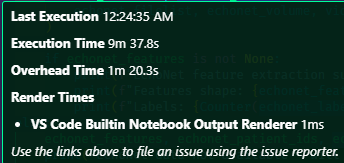

**With Pytorch Lightning** - eh, the same


### Run this Once if not already

In [ ]:
# if echonet_filelist is not None: # 15000
#     echonet_features, echonet_labels = extract_echonet_features_properly(
#         echonet_filelist, echonet_volume, videos_path, cnn_model, transform, max_samples=700000
#     )

#     if echonet_features is not None:
#         print(f"EchoNet feature extraction successful!")
#         print(f"Features shape: {echonet_features.shape}")
#         print(f"Labels: {Counter(echonet_labels)}")
# else:
#     echonet_features, echonet_patient_ids, echonet_labels = None, None, None
#     print("EchoNet data not available - will use Cleveland data only")

Extracting features from EchoNet data (max: 700000)...
Extracting metadata-based features from FileList.csv...
Available EchoNet features: ['EF', 'ESV', 'EDV', 'FrameHeight', 'FrameWidth', 'FPS', 'NumberOfFrames']
Adding volume tracing features...
Extracted EchoNet features shape: (10030, 64)
Label distribution: Counter({np.int64(0): 7784, np.int64(1): 2246})
No NaN in labels: True

Attempting video feature extraction for validation...
Video processing failed - using metadata features only
EchoNet feature extraction successful!
Features shape: (10030, 64)
Labels: Counter({np.int64(0): 7784, np.int64(1): 2246})


### save features locally

In [31]:
# # # Assuming echonet_features and echonet_labels are returned from the function
# if echonet_features is not None and echonet_labels is not None:
#     # Create a directory if it doesn't exist
#     save_dir = 'data/'
#     os.makedirs(save_dir, exist_ok=True)

#     # Save features
#     np.save(os.path.join(save_dir, 'echonet_features2.npy'), echonet_features)
#     print(f"Saved echonet_features to {save_dir}echonet_features2.npy")

#     # Save labels
#     np.save(os.path.join(save_dir, 'echonet_labels2.npy'), echonet_labels)
#     print(f"Saved echonet_labels to {save_dir}echonet_labels2.npy")
# else:
#     print("No data to save.")

### load features

In [32]:
echonet_features = np.load('data/echonet_features.npy')
echonet_labels = np.load('data/echonet_labels.npy')

In [33]:
print(len(echonet_labels))
print(echonet_labels)

10030
[0 0 0 ... 0 0 1]


In [ ]:
print(len(echonet_features))
print(echonet_features[:1])

10030
[[ 1.83901095e+00 -7.96790501e-01 -4.84306165e-01 -2.44655564e-02
  -2.44650362e-02 -1.72763439e-01 -4.37830300e-02  4.96714153e-03
  -1.38264301e-03  6.47688538e-03  1.52302986e-02 -2.34153375e-03
  -2.34136957e-03  1.57921282e-02  7.67434729e-03 -4.69474386e-03
   5.42560044e-03 -4.63417693e-03 -4.65729754e-03  2.41962272e-03
  -1.91328024e-02 -1.72491783e-02 -5.62287529e-03 -1.01283112e-02
   3.14247333e-03 -9.08024076e-03 -1.41230370e-02  1.46564877e-02
  -2.25776300e-03  6.75282047e-04 -1.42474819e-02 -5.44382725e-03
   1.10922590e-03 -1.15099358e-02  3.75698018e-03 -6.00638690e-03
  -2.91693750e-03 -6.01706612e-03  1.85227818e-02 -1.34972247e-04
  -1.05771093e-02  8.22544912e-03 -1.22084365e-02  2.08863595e-03
  -1.95967012e-02 -1.32818605e-02  1.96861236e-03  7.38466580e-03
   1.71368281e-03 -1.15648282e-03 -3.01103696e-03 -1.47852199e-02
  -7.19844208e-03 -4.60638771e-03  1.05712223e-02  3.43618290e-03
  -1.76304016e-02  3.24083969e-03 -3.85082280e-03 -6.76922000e-03
   6

## Advanced Feature Mapping and Alignment

In [34]:
from typing import Optional, Tuple

def create_realistic_multimodal_dataset(
    cleveland_X: pd.DataFrame,
    cleveland_y: pd.Series,
    echonet_features: Optional[np.ndarray] = None,
    echonet_labels: Optional[np.ndarray] = None,
    strategy: str = "synthetic_pairing"
) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, str, Optional[np.ndarray]]:
    """
    Create realistic multimodal dataset acknowledging Cleveland and EchoNet are DIFFERENT patients w

    This function addresses a key challenge in multimodal medical AI: the Cleveland/Sulianova
    dataset contains patient medical records (age, BP, cholesterol) while the EchoNet dataset
    contains echocardiogram videos from DIFFERENT patients. This function intelligently pairs
    these heterogeneous data sources for training a multimodal fusion model.

    PROBLEM BEING SOLVED
    - Cleveland/Sulianova: 70,000 patients with numerical health records
    - EchoNet: 10,000 DIFFERENT patients with echocardiogram videos
    - Goal: Train a model that uses BOTH numerical + video features
    - Challenge: These are different people! How do we pair them?

    PAIRING STRATEGIES
    1. **"synthetic_pairing"** (Default - Recommended)
    - Pairs patients with SAME disease label (0 or 1)
    - Creates balanced dataset: equal positive/negative samples
    - Cycles through available data if sizes don't match
    - Best for: Training robust fusion models

    Example:
    - Cleveland patient #5 (disease=1) + EchoNet video #12 (disease=1)
    - Cleveland patient #8 (disease=0) + EchoNet video #3 (disease=0)

    2. **"separate_cohorts"**
    - Keeps datasets more independent
    - Subsamples to match sizes
    - Pads features to same dimensions
    - Best for: Research comparing unimodal vs multimodal

    3. **"cleveland_only"** (Auto-selected when echonet_features=None)
    - Uses only numerical features (no video data)
    - Returns None for CNN features
    - Best for: Baseline model comparison
    """

    print("="*60)
    print("REALISTIC MULTIMODAL DATASET CREATION")
    print("="*60)
    print("Acknowledging: Cleveland and EchoNet represent different patient populations")

    if echonet_features is None:
        print("\nStrategy: Cleveland data only")
        return cleveland_X.values, None, cleveland_y.values, "cleveland_only", None

    print(f"\nDataset Statistics:")
    print(f"- Data (sulianova_data): {cleveland_X.shape[0]} patients, \n {cleveland_y} disease rate \n")
    print(f"- EchoNet: {echonet_features.shape[0]} patients, \n {echonet_labels} disease rate \n")


    cle_pos_idx = cleveland_y[cleveland_y == 1].index.tolist()
    cle_neg_idx = cleveland_y[cleveland_y == 0].index.tolist()

    echo_pos_idx = np.where(echonet_labels == 1)[0]
    echo_neg_idx = np.where(echonet_labels == 0)[0]

    print(f"Available for pairing:")
    print(f"  Cleveland: {len(cle_pos_idx)} positive, {len(cle_neg_idx)} negative")
    print(f"  EchoNet: {len(echo_pos_idx)} positive, {len(echo_neg_idx)} negative")

    # Create balanced pairs
    max_pos = min(len(cle_pos_idx), len(echo_pos_idx))
    max_neg = min(len(cle_neg_idx), len(echo_neg_idx))
    n_pairs_per_class = min(max_pos, max_neg, 60)

    if strategy == "synthetic_pairing":
        paired_cleveland, paired_echonet, paired_labels = [], [], []
        group_ids = []

        # Positive pairs
        for i in range(max_pos):
            cle_idx = cle_pos_idx[i % len(cle_pos_idx)]
            echo_idx = echo_pos_idx[i % len(echo_pos_idx)]
            paired_cleveland.append(cleveland_X.iloc[cle_idx].values)
            paired_echonet.append(echonet_features[echo_idx])
            paired_labels.append(1)
            group_ids.append(cle_idx)

        # Negative pairs
        for i in range(max_neg):
            cle_idx = cle_neg_idx[i % len(cle_neg_idx)]
            echo_idx = echo_neg_idx[i % len(echo_neg_idx)]
            paired_cleveland.append(cleveland_X.iloc[cle_idx].values)
            paired_echonet.append(echonet_features[echo_idx])
            paired_labels.append(0)
            group_ids.append(cle_idx)

        final_cleveland = np.array(paired_cleveland)
        final_echonet   = np.array(paired_echonet)
        final_labels    = np.array(paired_labels)
        group_ids       = np.array(group_ids)

        return final_cleveland, final_echonet, final_labels, "synthetic_pairing", group_ids

    elif strategy == "separate_cohorts":
        print("\nStrategy 2: SEPARATE COHORTS approach")
        print("Rationale: Use both datasets independently, combine at training time")

        # Use all Cleveland data
        all_cleveland = cleveland_X.values
        all_cleveland_labels = cleveland_y.values

        # Subsample EchoNet to match Cleveland size approximately
        n_echo_samples = min(len(echonet_features), len(all_cleveland))
        echo_indices = np.random.choice(len(echonet_features), n_echo_samples, replace=False)

        selected_echonet = echonet_features[echo_indices]
        selected_echo_labels = echonet_labels[echo_indices] # type: ignore

        # Pad features to same dimension
        if all_cleveland.shape[1] != selected_echonet.shape[1]:
            max_dim = max(all_cleveland.shape[1], selected_echonet.shape[1])

            if all_cleveland.shape[1] < max_dim:
                pad_cle = np.zeros((all_cleveland.shape[0], max_dim - all_cleveland.shape[1]))
                all_cleveland = np.hstack([all_cleveland, pad_cle])

            if selected_echonet.shape[1] < max_dim:
                pad_echo = np.zeros((selected_echonet.shape[0], max_dim - selected_echonet.shape[1]))
                selected_echonet = np.hstack([selected_echonet, pad_echo])

        # Create combined dataset marking data source
        combined_cleveland = all_cleveland[:n_echo_samples]  # Match sizes
        combined_labels = all_cleveland_labels[:n_echo_samples]
        group_ids = np.arange(len(combined_labels))

        print(f"Separate cohorts approach:")
        print(f"  Cleveland subset: {combined_cleveland.shape}")
        print(f"  EchoNet subset: {selected_echonet.shape}")
        print(f"  Combined labels: {Counter(combined_labels)}")

        return combined_cleveland, selected_echonet, combined_labels, "separate_cohorts", group_ids

    else:
        print("Using default synthetic pairing strategy")
        return create_realistic_multimodal_dataset(cleveland_X, cleveland_y, echonet_features, echonet_labels, "synthetic_pairing")

In [35]:
print(f'cleveland_X_processed, cleveland_y: {len(cleveland_X_processed)} - {len(cleveland_y)}')
print(f'echonet_features, echonet_labels: {len(echonet_features)} - {len(echonet_labels)}')

cleveland_X_processed, cleveland_y: 70001 - 70001
echonet_features, echonet_labels: 10030 - 10030


In [36]:
if cleveland_X_processed is not None:
    aligned_numerical, aligned_cnn_features, aligned_labels, alignment_strategy, group_ids = create_realistic_multimodal_dataset(
        cleveland_X_processed, cleveland_y, echonet_features, echonet_labels, strategy="synthetic_pairing"
    )

REALISTIC MULTIMODAL DATASET CREATION
Acknowledging: Cleveland and EchoNet represent different patient populations

Dataset Statistics:
- Data (sulianova_data): 70001 patients, 
 0        cardio
1             0
2             1
3             1
4             1
          ...  
69996         0
69997         1
69998         1
69999         1
70000         0
Name: cardio, Length: 70001, dtype: object disease rate 

- EchoNet: 10030 patients, 
 [0 0 0 ... 0 0 1] disease rate 

Available for pairing:
  Cleveland: 2205 positive, 2260 negative
  EchoNet: 2246 positive, 7784 negative


In [37]:
print(f"\nFinal aligned dataset:")
print(f"- Strategy used: {alignment_strategy}")
print(f"- Numerical features: {aligned_numerical.shape}")
print(f"- CNN features: {aligned_cnn_features.shape if aligned_cnn_features is not None else 'None'}")
print(f"- Labels: {Counter(aligned_labels)}")
print(f"- No NaN labels: {not np.isnan(aligned_labels).any()}")


Final aligned dataset:
- Strategy used: synthetic_pairing
- Numerical features: (4465, 28)
- CNN features: (4465, 64)
- Labels: Counter({np.int64(0): 2260, np.int64(1): 2205})
- No NaN labels: True


In [38]:
print((echonet_filelist['EF'] < 50).astype(int).value_counts())

EF
0    7784
1    2246
Name: count, dtype: int64


In [39]:
print(pd.Series(echonet_labels).value_counts())

0    7784
1    2246
Name: count, dtype: int64


In [40]:
print(echonet_features.shape)

(10030, 64)


In [41]:
print(cleveland_X_processed.shape)

(70001, 28)


In [42]:
print(aligned_numerical.shape)

(4465, 28)


In [43]:
def visualize_video_frame_extraction(echonet_filelist, videos_path, transform, max_videos=3, frames_per_video=4):
    """
    Visualize example frames extracted from EchoNet videos
    Shows original frames vs preprocessed frames
    """
    print("Visualizing video frame extraction examples...")

    if videos_path is None or echonet_filelist is None:
        print("Videos or metadata not available for visualization")
        return

    # Get available video files
    video_files = [f for f in os.listdir(videos_path) if f.endswith('.avi')]

    if len(video_files) == 0:
        print("No video files found")
        return

    print(f"Found {len(video_files)} video files, processing {max_videos} for visualization")

    # Create figure
    fig, axes = plt.subplots(max_videos, frames_per_video * 2, figsize=(20, 6 * max_videos))

    if max_videos == 1:
        axes = axes.reshape(1, -1)

    processed_videos = 0

    for video_file in video_files[:max_videos]:
        video_path = os.path.join(videos_path, video_file)
        video_name = video_file.replace('.avi', '')

        # Get metadata for this video
        video_metadata = echonet_filelist[echonet_filelist['FileName'] == video_name]

        if video_metadata.empty:
            continue

        try:
            # Extract frames from video
            cap = cv2.VideoCapture(video_path)

            if not cap.isOpened():
                continue

            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            fps = cap.get(cv2.CAP_PROP_FPS)

            print(f"Video {processed_videos + 1}: {video_name}")
            print(f"  Total frames: {total_frames}, FPS: {fps:.1f}")

            if not video_metadata.empty:
                ef_value = video_metadata['EF'].iloc[0]
                heart_disease = video_metadata['heart_disease'].iloc[0]
                print(f"  EF: {ef_value:.1f}%, Heart Disease: {'Yes' if heart_disease else 'No'}")

            frames = []
            frame_numbers = []

            # Extract frames at regular intervals
            frame_interval = max(1, total_frames // (frames_per_video + 2))  # Skip some frames

            for i in range(frames_per_video):
                frame_num = (i + 1) * frame_interval
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
                ret, frame = cap.read()

                if ret and frame is not None:
                    # Convert BGR to RGB
                    if len(frame.shape) == 3:
                        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        frames.append(frame_rgb)
                        frame_numbers.append(frame_num)

            cap.release()

            # Visualize frames
            for frame_idx, (frame, frame_num) in enumerate(zip(frames, frame_numbers)):
                if frame_idx >= frames_per_video:
                    break

                # Original frame
                col_idx = frame_idx * 2
                axes[processed_videos, col_idx].imshow(frame)
                axes[processed_videos, col_idx].set_title(f'Original Frame {frame_num}\n{frame.shape}', fontsize=10)
                axes[processed_videos, col_idx].axis('off')

                # Preprocessed frame
                try:
                    frame_pil = Image.fromarray(frame.astype(np.uint8))
                    frame_tensor = transform(frame_pil)

                    # Convert back to numpy for visualization
                    frame_preprocessed = frame_tensor.permute(1, 2, 0).numpy()

                    # Denormalize for visualization
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    frame_preprocessed = frame_preprocessed * std + mean
                    frame_preprocessed = np.clip(frame_preprocessed, 0, 1)

                    col_idx = frame_idx * 2 + 1
                    axes[processed_videos, col_idx].imshow(frame_preprocessed)
                    axes[processed_videos, col_idx].set_title(f'Preprocessed\n224x224 Normalized', fontsize=10)
                    axes[processed_videos, col_idx].axis('off')

                except Exception as e:
                    print(f"Error preprocessing frame {frame_idx}: {e}")
                    col_idx = frame_idx * 2 + 1
                    axes[processed_videos, col_idx].text(0.5, 0.5, 'Preprocessing\nFailed',
                                                        ha='center', va='center', transform=axes[processed_videos, col_idx].transAxes)
                    axes[processed_videos, col_idx].axis('off')

            processed_videos += 1

        except Exception as e:
            print(f"Error processing video {video_file}: {e}")
            continue

    # Hide unused subplots
    for i in range(processed_videos, max_videos):
        for j in range(frames_per_video * 2):
            axes[i, j].axis('off')

    plt.suptitle(f'EchoNet Video Frame Extraction Examples\nShowing {processed_videos} videos with original vs preprocessed frames',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"Visualization complete: {processed_videos} videos processed")
    return processed_videos

Visualizing video frame extraction examples...
Found 10030 video files, processing 3 for visualization
Video 1: 0X100009310A3BD7FC
  Total frames: 174, FPS: 50.0
Error processing video 0X100009310A3BD7FC.avi: 'heart_disease'
Video 1: 0X1002E8FBACD08477
  Total frames: 215, FPS: 50.0
Error processing video 0X1002E8FBACD08477.avi: 'heart_disease'
Video 1: 0X1005D03EED19C65B
  Total frames: 104, FPS: 50.0
Error processing video 0X1005D03EED19C65B.avi: 'heart_disease'


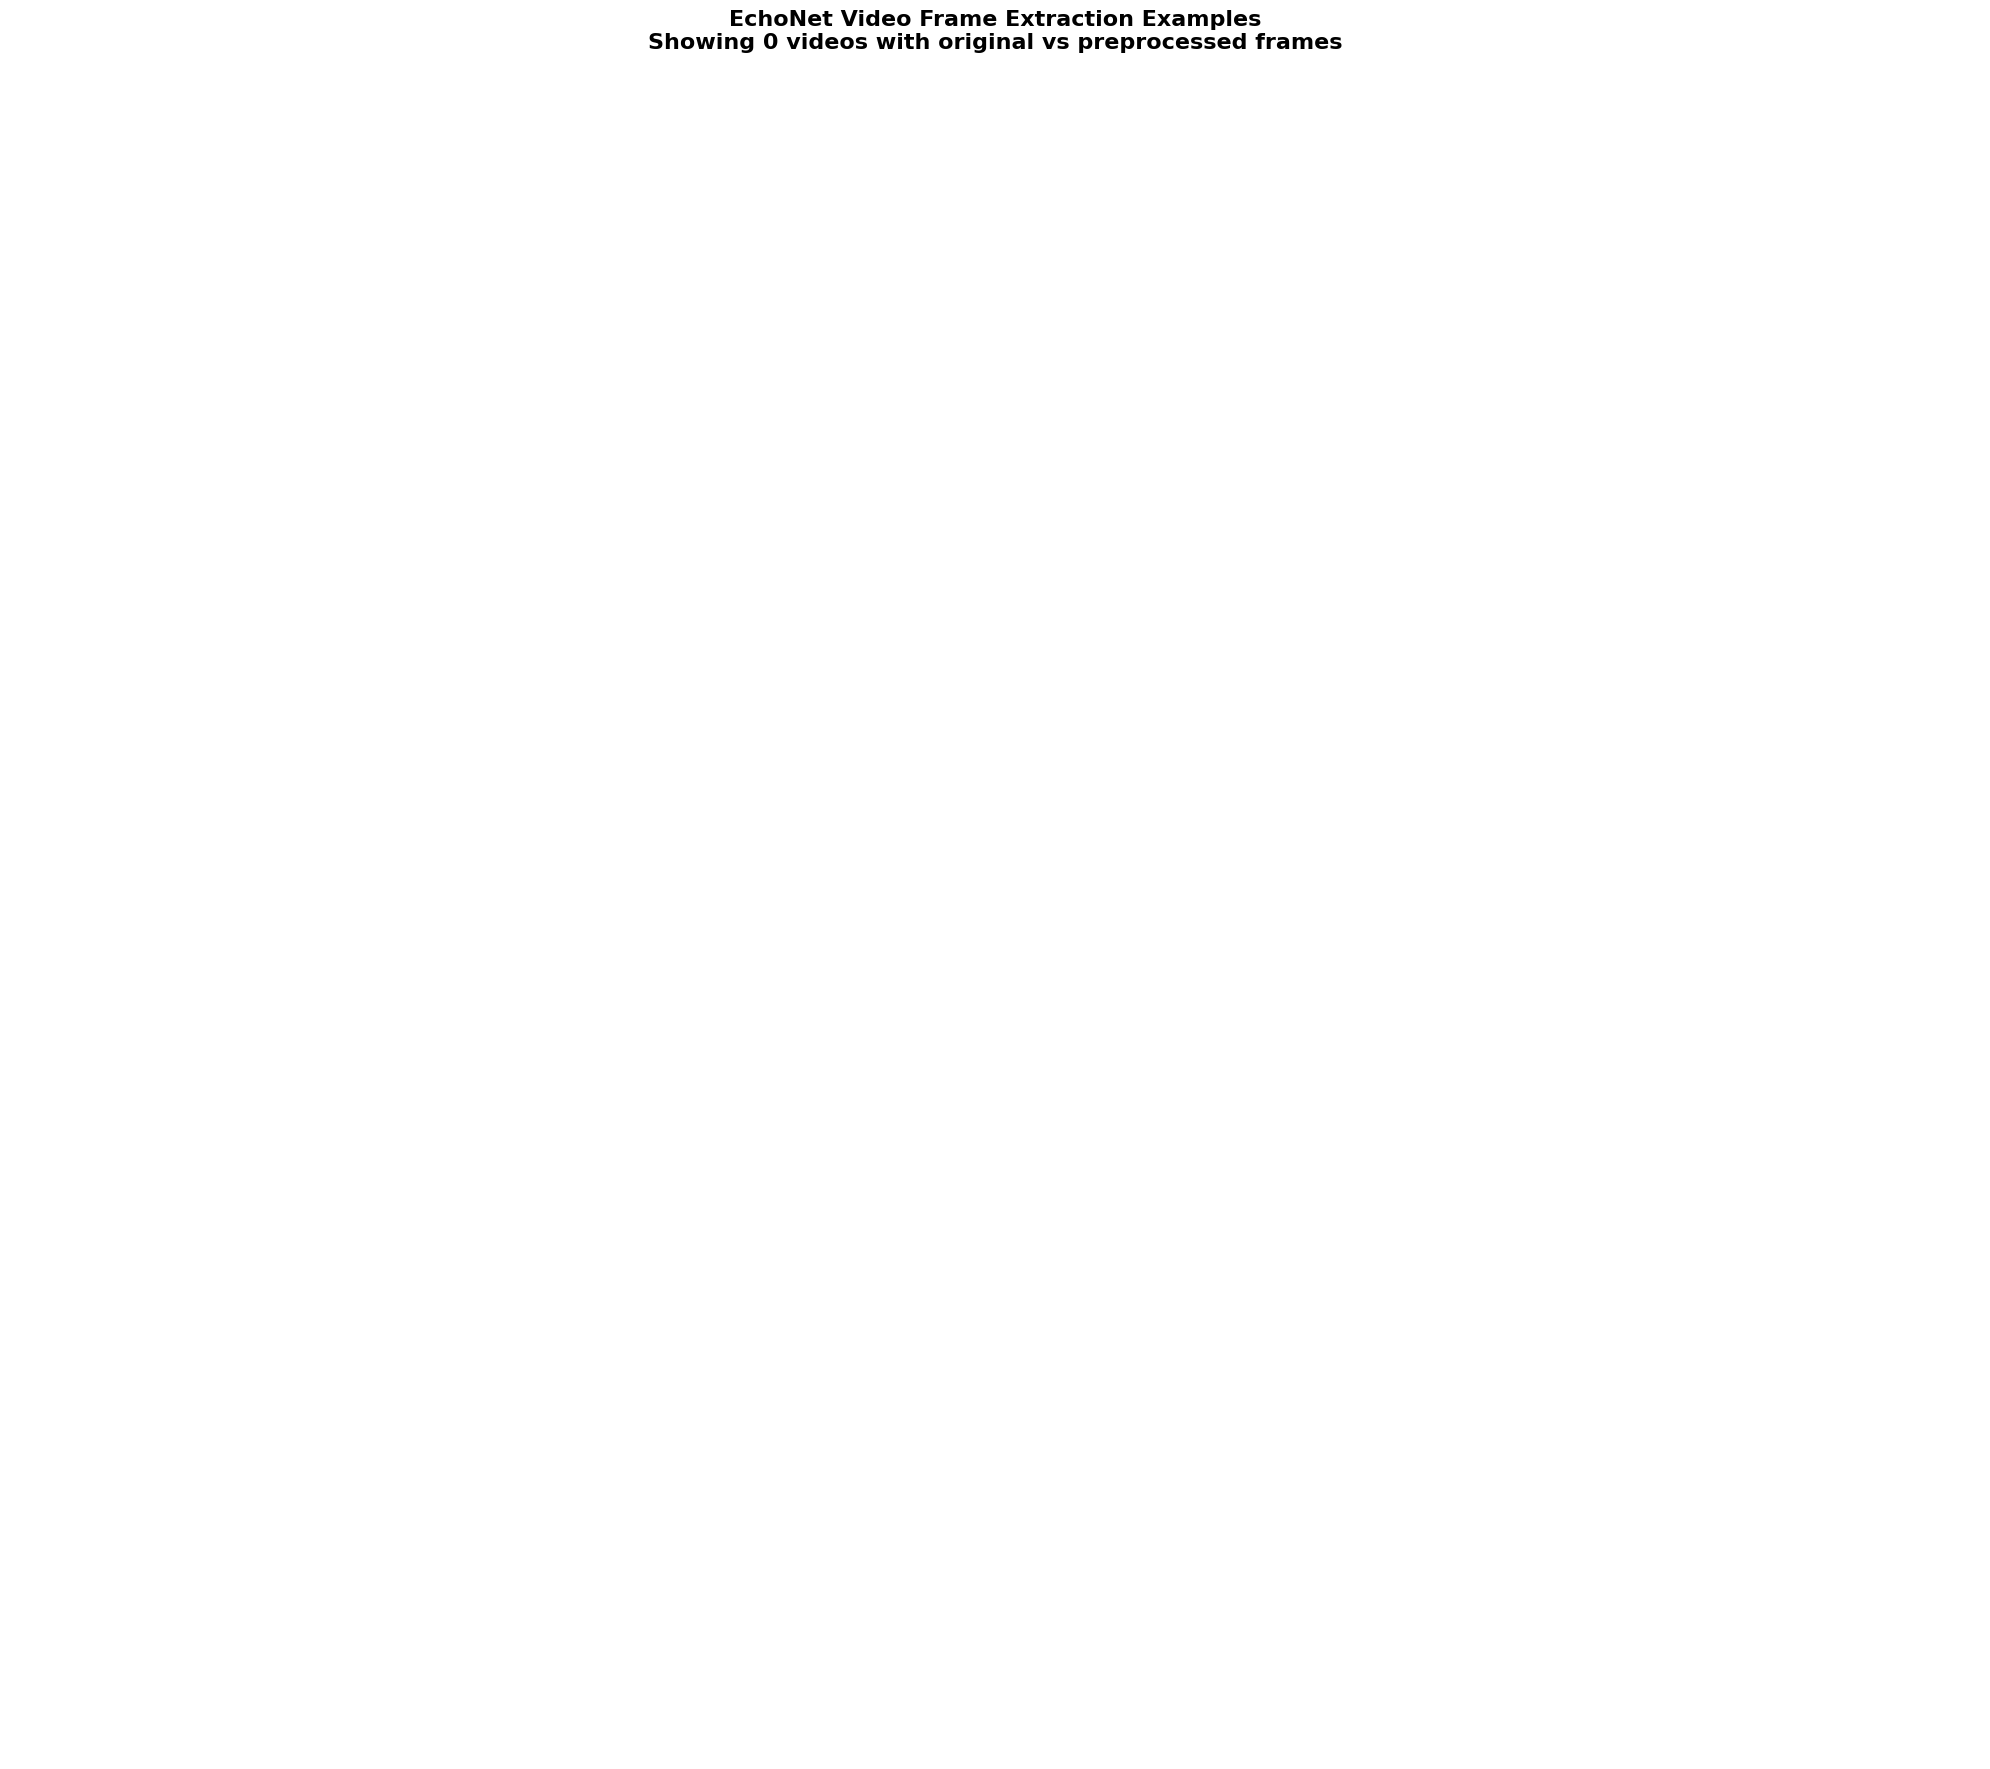

Visualization complete: 0 videos processed


In [44]:
visualized_count = visualize_video_frame_extraction(
    echonet_filelist, videos_path, transform, max_videos=3, frames_per_video=3
)

## Train feature fusion model

In [45]:
from sklearn.model_selection import StratifiedKFold


def train_fusion_model(
    aligned_numerical,
    aligned_cnn_features,
    aligned_labels,
    epochs=100,
    batch_size=7000000,
    learning_rate=0.001,
    groups=None,
    seed=42,
    n_folds=5
):
    """Train the CNN+MLP feature fusion model with 5-fold cross-validation."""
    print("="*50)
    print("TRAINING FEATURE FUSION MODEL - 5-FOLD CV")
    print("="*50)

    rng = np.random.default_rng(seed)
    torch.manual_seed(seed)

    # Prepare indices and labels
    indices = np.arange(len(aligned_numerical))
    y_np = np.asarray(aligned_labels, dtype=int)

    # Select appropriate cross-validation strategy
    if groups is not None:
        print(f"Using GroupKFold with {n_folds} folds")
        cv_splitter = GroupKFold(n_splits=n_folds)
        splits = cv_splitter.split(indices, y_np, groups=groups)
    else:
        print(f"Using StratifiedKFold with {n_folds} folds")
        cv_splitter = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
        splits = cv_splitter.split(indices, y_np)

    # Store results from each fold
    fold_results = []
    all_y_test = []
    all_y_pred = []
    all_test_accuracies = []

    # Get numerical dimension for model creation
    numerical_dim = aligned_numerical.shape[1]

    # Iterate through each fold
    for fold_idx, (train_idx, test_idx) in enumerate(splits):
        print(f"\n{'='*50}")
        print(f"FOLD {fold_idx + 1}/{n_folds}")
        print(f"{'='*50}")

        # Create a fresh model for each fold
        fusion_model = create_fusion_model(numerical_dim)

        # Fit scalers on TRAIN fold only (prevent data leakage)
        num_scaler = StandardScaler().fit(aligned_numerical[train_idx])
        X_train_num_np = num_scaler.transform(aligned_numerical[train_idx])
        X_test_num_np = num_scaler.transform(aligned_numerical[test_idx])

        if aligned_cnn_features is not None:
            cnn_scaler = StandardScaler().fit(aligned_cnn_features[train_idx])
            X_train_cnn_np = cnn_scaler.transform(aligned_cnn_features[train_idx])
            X_test_cnn_np = cnn_scaler.transform(aligned_cnn_features[test_idx])
            if fold_idx == 0:  # Print once
                print("Training with both numerical and CNN features (multimodal)")
        else:
            X_train_cnn_np = X_test_cnn_np = None
            if fold_idx == 0:  # Print once
                print("Training with numerical features only")

        # Convert to torch tensors
        X_train_num = torch.tensor(X_train_num_np, dtype=torch.float32)
        X_test_num = torch.tensor(X_test_num_np, dtype=torch.float32)
        y_train = torch.tensor(y_np[train_idx], dtype=torch.long)
        y_test = torch.tensor(y_np[test_idx], dtype=torch.long)

        if X_train_cnn_np is not None:
            X_train_cnn = torch.tensor(X_train_cnn_np, dtype=torch.float32)
            X_test_cnn = torch.tensor(X_test_cnn_np, dtype=torch.float32)
        else:
            X_train_cnn = X_test_cnn = None

        print(f"Training set: {len(X_train_num)} samples")
        print(f"Test set: {len(X_test_num)} samples")
        print(f"Class distribution - Train: {Counter(y_train.numpy())}")
        print(f"Class distribution - Test: {Counter(y_test.numpy())}")

        # Calculate class weights for balanced training
        class_counts = np.bincount(y_train.numpy(), minlength=2)
        class_weights = (class_counts.sum() / (class_counts + 1e-6)).astype(np.float32)
        class_weights = class_weights / class_weights.mean()  # normalize
        criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights))

        # Optimizer and scheduler
        optimizer = optim.Adam(fusion_model.parameters(), lr=learning_rate, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

        ## Training loop for this fold
        fusion_model.train()
        train_losses = []
        train_accuracies = []

        n_train = X_train_num.size(0)
        if batch_size is None or batch_size >= n_train:
            actual_batch_size = n_train
        else:
            actual_batch_size = batch_size

        for epoch in range(epochs):
            # Shuffle data each epoch
            perm = torch.randperm(n_train)
            X_train_num_shuffled = X_train_num[perm]
            y_train_shuffled = y_train[perm]
            X_train_cnn_shuffled = X_train_cnn[perm] if X_train_cnn is not None else None

            total_loss = 0.0
            correct = 0
            total = 0

            # Calculate number of batches
            n_batches = (n_train + actual_batch_size - 1) // actual_batch_size

            for b in range(n_batches):
                s = b * actual_batch_size
                e = min((b + 1) * actual_batch_size, n_train)

                batch_num = X_train_num_shuffled[s:e]
                batch_lbl = y_train_shuffled[s:e]
                batch_cnn = X_train_cnn_shuffled[s:e] if X_train_cnn_shuffled is not None else None

                optimizer.zero_grad()
                outputs, _ = fusion_model(batch_num, batch_cnn)
                loss = criterion(outputs, batch_lbl)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                _, pred = outputs.max(1)
                total += batch_lbl.size(0)
                correct += (pred == batch_lbl).sum().item()

            scheduler.step()
            epoch_loss = total_loss / n_batches
            epoch_acc = 100.0 * correct / total
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)

            # Print progress every 20 epochs
            if (epoch + 1) % 20 == 0:
                print(f"Epoch [{epoch+1}/{epochs}]  Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.2f}%")

        # Evaluate on test fold (moved outside the epoch loop)
        fusion_model.eval()
        with torch.no_grad():
            test_outputs, test_features = fusion_model(X_test_num, X_test_cnn)
            test_probs = torch.softmax(test_outputs, dim=1)
            _, test_predicted = test_outputs.max(1)
            test_accuracy = (test_predicted == y_test).float().mean().item()

        # Store results for this fold (moved outside the epoch loop)
        fold_result = {
            "fold": fold_idx + 1,
            "model": fusion_model,
            "test_accuracy": test_accuracy,
            "y_test": y_test.cpu().numpy(),
            "y_pred": test_predicted.cpu().numpy(),
            "y_probs": test_probs.cpu().numpy(),
            "train_losses": train_losses,
            "train_accuracies": train_accuracies,
            "final_train_loss": train_losses[-1],
            "final_train_acc": train_accuracies[-1],
            "num_scaler": num_scaler,
            "cnn_scaler": cnn_scaler if aligned_cnn_features is not None else None
        }

        fold_results.append(fold_result)
        all_y_test.extend(y_test.cpu().numpy())
        all_y_pred.extend(test_predicted.cpu().numpy())
        all_test_accuracies.append(test_accuracy)

        print(f"\nFold {fold_idx + 1} Results:")
        print(f"  Test Accuracy: {test_accuracy:.4f}")
        print(f"  Final Training Loss: {train_losses[-1]:.4f}")
        print(f"  Final Training Accuracy: {train_accuracies[-1]:.2f}%")

    # Aggregate results across all folds
    print(f"\n{'='*50}")
    print("CROSS-VALIDATION RESULTS SUMMARY")
    print(f"{'='*50}")

    mean_accuracy = np.mean(all_test_accuracies)
    std_accuracy = np.std(all_test_accuracies)

    print(f"\nTest Accuracy across {n_folds} folds:")
    for i, acc in enumerate(all_test_accuracies):
        print(f"  Fold {i+1}: {acc:.4f}")
    print(f"\nMean Test Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"Min Test Accuracy: {np.min(all_test_accuracies):.4f}")
    print(f"Max Test Accuracy: {np.max(all_test_accuracies):.4f}")

    # Calculate overall metrics from all predictions
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    overall_accuracy = accuracy_score(all_y_test, all_y_pred)
    overall_precision = precision_score(all_y_test, all_y_pred, average='binary', zero_division=0)
    overall_recall = recall_score(all_y_test, all_y_pred, average='binary', zero_division=0)
    overall_f1 = f1_score(all_y_test, all_y_pred, average='binary', zero_division=0)

    print(f"\nOverall Metrics (aggregated from all folds):")
    print(f"  Accuracy: {overall_accuracy:.4f}")
    print(f"  Precision: {overall_precision:.4f}")
    print(f"  Recall: {overall_recall:.4f}")
    print(f"  F1-Score: {overall_f1:.4f}")

    # Return comprehensive results
    results = {
        "fold_results": fold_results,
        "mean_test_accuracy": mean_accuracy,
        "std_test_accuracy": std_accuracy,
        "all_test_accuracies": all_test_accuracies,
        "all_y_test": np.array(all_y_test),
        "all_y_pred": np.array(all_y_pred),
        "overall_accuracy": overall_accuracy,
        "overall_precision": overall_precision,
        "overall_recall": overall_recall,
        "overall_f1": overall_f1,
        "n_folds": n_folds,
        "best_fold": np.argmax(all_test_accuracies) + 1,
        "best_accuracy": np.max(all_test_accuracies),
        "worst_fold": np.argmin(all_test_accuracies) + 1,
        "worst_accuracy": np.min(all_test_accuracies)
    }

    return results


In [46]:
if 'aligned_numerical' in locals() and aligned_numerical is not None:
    fusion_results = train_fusion_model(
        aligned_numerical,
        aligned_cnn_features,
        aligned_labels,
        epochs=100,
        batch_size=32,
        learning_rate=0.001,
        groups=None,  # or provide group IDs for GroupKFold
        seed=42,
        n_folds=5
    )

    print(f"\nFusion Model Training Completed!")


TRAINING FEATURE FUSION MODEL - 5-FOLD CV
Using StratifiedKFold with 5 folds

FOLD 1/5
Training with both numerical and CNN features (multimodal)
Training set: 3572 samples
Test set: 893 samples
Class distribution - Train: Counter({np.int64(0): 1808, np.int64(1): 1764})
Class distribution - Test: Counter({np.int64(0): 452, np.int64(1): 441})
Epoch [20/100]  Loss: 0.0092  Acc: 99.75%
Epoch [40/100]  Loss: 0.0012  Acc: 99.94%
Epoch [60/100]  Loss: 0.0005  Acc: 100.00%
Epoch [80/100]  Loss: 0.0001  Acc: 100.00%
Epoch [100/100]  Loss: 0.0006  Acc: 99.97%

Fold 1 Results:
  Test Accuracy: 0.9832
  Final Training Loss: 0.0006
  Final Training Accuracy: 99.97%

FOLD 2/5
Training set: 3572 samples
Test set: 893 samples
Class distribution - Train: Counter({np.int64(0): 1808, np.int64(1): 1764})
Class distribution - Test: Counter({np.int64(0): 452, np.int64(1): 441})
Epoch [20/100]  Loss: 0.0075  Acc: 99.75%
Epoch [40/100]  Loss: 0.0024  Acc: 99.92%
Epoch [60/100]  Loss: 0.0007  Acc: 99.97%
Epoc

In [47]:
print(fusion_results)

{'fold_results': [{'fold': 1, 'model': FeatureFusionModel(
  (numerical_mlp): NumericalMLP(
    (mlp): Sequential(
      (0): Linear(in_features=28, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.3, inplace=False)
      (6): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (fusion_layer): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=2, bias=True)
  )
), 'test_accuracy': 0.9832026958465576, 'y_test': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [48]:
def visualize_all_folds(fusion_results):
    """Visualize results from all folds in cross-validation"""

    print("="*70)
    print("VISUALIZING ALL FOLDS")
    print("="*70)

    n_folds = fusion_results['n_folds']
    fold_results = fusion_results['fold_results']

    # Add assertions for debugging
    assert len(fold_results) == n_folds, f"Mismatch: len(fold_results)={len(fold_results)} != n_folds={n_folds}"
    for i, fold in enumerate(fold_results):
        assert len(fold['train_losses']) == 100, f"Fold {i+1}: train_losses length {len(fold['train_losses'])} != 100"
        assert len(fold['train_accuracies']) == 100, f"Fold {i+1}: train_accuracies length {len(fold['train_accuracies'])} != 100"

    print(f"Number of folds: {n_folds}")
    print(f"Mean Test Accuracy: {fusion_results['mean_test_accuracy']:.4f} ± {fusion_results['std_test_accuracy']:.4f}")

    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

    # 1. TEST ACCURACY ACROSS FOLDS
    ax1 = fig.add_subplot(gs[0, 0])

    fold_numbers = [f"Fold {i+1}" for i in range(n_folds)]
    accuracies = [fold['test_accuracy'] for fold in fold_results]
    colors = ['green' if i == fusion_results['best_fold']-1 else
              'red' if i == fusion_results['worst_fold']-1 else 'steelblue'
              for i in range(n_folds)]

    # Fix: Use numerical x to avoid string broadcasting issues
    x = np.arange(n_folds)
    bars = ax1.bar(x, accuracies, color=colors, alpha=0.7, edgecolor='black')
    ax1.axhline(y=fusion_results['mean_test_accuracy'], color='red',
                linestyle='--', linewidth=2, label=f'Mean: {fusion_results["mean_test_accuracy"]:.4f}')
    ax1.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
    ax1.set_title('Test Accuracy Across All Folds', fontsize=14, fontweight='bold')
    ax1.set_ylim([0, 1.1])
    ax1.set_xticks(x)
    ax1.set_xticklabels(fold_numbers)  # Set string labels on numerical ticks
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')


    # 2. TRAINING LOSS CURVES - ALL FOLDS
    ax2 = fig.add_subplot(gs[0, 1])

    for i, fold in enumerate(fold_results):
        ax2.plot(fold['train_losses'], label=f'Fold {i+1}', alpha=0.7, linewidth=2)

    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax2.set_title('Training Loss - All Folds', fontsize=14, fontweight='bold')
    ax2.legend(loc='best', fontsize=9)
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')

    # 3. TRAINING ACCURACY CURVES - ALL FOLDS
    ax3 = fig.add_subplot(gs[0, 2])

    for i, fold in enumerate(fold_results):
        ax3.plot(fold['train_accuracies'], label=f'Fold {i+1}', alpha=0.7, linewidth=2)

    ax3.set_xlabel('Epoch', fontsize=12)
    ax3.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax3.set_title('Training Accuracy - All Folds', fontsize=14, fontweight='bold')
    ax3.legend(loc='best', fontsize=9)
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim([0, 105])


    # 4. COMBINED CONFUSION MATRIX (ALL FOLDS)
    ax4 = fig.add_subplot(gs[1, 0])

    # Aggregate confusion matrix from all folds
    cm_combined = confusion_matrix(fusion_results['all_y_test'],
                                   fusion_results['all_y_pred'])

    sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Blues', ax=ax4,
                cbar_kws={'label': 'Count'}, square=True)
    ax4.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax4.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax4.set_title('Combined Confusion Matrix\n(All Folds)', fontsize=14, fontweight='bold')
    ax4.set_xticklabels(['No Disease', 'Disease'])
    ax4.set_yticklabels(['No Disease', 'Disease'])

    # 5. INDIVIDUAL FOLD CONFUSION MATRICES (SMALL MULTIPLES)
    ax5 = fig.add_subplot(gs[1, 1:])

    # Create small confusion matrices for each fold
    n_cols = 3
    n_rows = (n_folds + n_cols - 1) // n_cols

    fig_cm, axes_cm = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))
    axes_cm = axes_cm.flatten() if n_folds > 1 else [axes_cm]

    for i, fold in enumerate(fold_results):
        cm_fold = confusion_matrix(fold['y_test'], fold['y_pred'])
        sns.heatmap(cm_fold, annot=True, fmt='d', cmap='Greens', ax=axes_cm[i],
                   cbar=False, square=True)
        axes_cm[i].set_title(f'Fold {i+1} (Acc: {fold["test_accuracy"]:.3f})',
                            fontsize=11, fontweight='bold')
        axes_cm[i].set_xlabel('Predicted')
        axes_cm[i].set_ylabel('True')

    # Hide unused subplots
    for i in range(n_folds, len(axes_cm)):
        axes_cm[i].axis('off')

    fig_cm.tight_layout()
    fig_cm.suptitle('Individual Fold Confusion Matrices', fontsize=16, fontweight='bold', y=1.02)

    # Hide the placeholder in main figure
    ax5.axis('off')
    ax5.text(0.5, 0.5, 'See separate figure for\nindividual fold confusion matrices',
            ha='center', va='center', fontsize=12, style='italic',
            transform=ax5.transAxes)


    # 6. ROC CURVES - ALL FOLDS
    ax6 = fig.add_subplot(gs[2, 0])

    for i, fold in enumerate(fold_results):
        fpr, tpr, _ = roc_curve(fold['y_test'], fold['y_probs'][:, 1])
        roc_auc = auc(fpr, tpr)
        ax6.plot(fpr, tpr, alpha=0.7, linewidth=2,
                label=f'Fold {i+1} (AUC={roc_auc:.3f})')

    # Plot diagonal
    ax6.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random', alpha=0.5)

    ax6.set_xlim([0.0, 1.0])
    ax6.set_ylim([0.0, 1.05])
    ax6.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    ax6.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    ax6.set_title('ROC Curves - All Folds', fontsize=14, fontweight='bold')
    ax6.legend(loc='lower right', fontsize=9)
    ax6.grid(True, alpha=0.3)


    # 7. PERFORMANCE METRICS COMPARISON
    ax7 = fig.add_subplot(gs[2, 1])

    # Calculate metrics for each fold
    metrics_per_fold = []
    for fold in fold_results:
        precision, recall, f1, _ = precision_recall_fscore_support(
            fold['y_test'], fold['y_pred'], average='weighted', zero_division=0
        )
        metrics_per_fold.append({
            'Accuracy': fold['test_accuracy'],
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })

    # Create grouped bar chart
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    x = np.arange(len(metric_names))
    width = 0.15

    for i in range(n_folds):
        values = [metrics_per_fold[i][m] for m in metric_names]
        ax7.bar(x + i*width, values, width, label=f'Fold {i+1}', alpha=0.8)

    ax7.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax7.set_title('Performance Metrics - All Folds', fontsize=14, fontweight='bold')
    ax7.set_xticks(x + width * (n_folds-1) / 2)
    ax7.set_xticklabels(metric_names)
    ax7.legend(loc='lower right', fontsize=9)
    ax7.set_ylim([0, 1.1])
    ax7.grid(True, alpha=0.3, axis='y')


    # 8. OVERALL METRICS SUMMARY
    ax8 = fig.add_subplot(gs[2, 2])

    overall_metrics = {
        'Accuracy': fusion_results['overall_accuracy'],
        'Precision': fusion_results['overall_precision'],
        'Recall': fusion_results['overall_recall'],
        'F1-Score': fusion_results['overall_f1']
    }

    colors_bar = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    bars = ax8.bar(overall_metrics.keys(), overall_metrics.values(),
                    color=colors_bar, alpha=0.8, edgecolor='black', linewidth=2)
    ax8.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax8.set_title('Overall Metrics\n(Aggregated from All Folds)', fontsize=14, fontweight='bold')
    ax8.set_ylim([0, 1.1]) # type: ignore

    for bar, (metric, value) in zip(bars, overall_metrics.items()):
        ax8.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{value:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')


    # 9. TRAINING TIME / CONVERGENCE ANALYSIS
    ax9 = fig.add_subplot(gs[3, 0])

    # Final training accuracy for each fold
    final_train_accs = [fold['final_train_acc'] for fold in fold_results]
    test_accs = [fold['test_accuracy'] * 100 for fold in fold_results]  # Convert to percentage

    x_pos = np.arange(n_folds)
    width = 0.35

    bars1 = ax9.bar(x_pos - width/2, final_train_accs, width,
                    label='Train Acc', color='skyblue', alpha=0.8)
    bars2 = ax9.bar(x_pos + width/2, test_accs, width,
                    label='Test Acc', color='salmon', alpha=0.8)

    ax9.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax9.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax9.set_title('Train vs Test Accuracy', fontsize=14, fontweight='bold')
    ax9.set_xticks(x_pos)
    ax9.set_xticklabels([f'Fold {i+1}' for i in range(n_folds)])
    ax9.legend()
    ax9.grid(True, alpha=0.3, axis='y')


    # 10. CLASS DISTRIBUTION ACROSS FOLDS
    ax10 = fig.add_subplot(gs[3, 1])

    class_0_counts = []
    class_1_counts = []

    for fold in fold_results:
        class_dist = Counter(fold['y_test'])
        class_0_counts.append(class_dist.get(0, 0))
        class_1_counts.append(class_dist.get(1, 0))

    x_pos = np.arange(n_folds)
    width = 0.4

    ax10.bar(x_pos - width/2, class_0_counts, width, label='No Disease (0)',
            color='#98D8C8', alpha=0.8, edgecolor='black')
    ax10.bar(x_pos + width/2, class_1_counts, width, label='Disease (1)',
            color='#F7DC6F', alpha=0.8, edgecolor='black')

    ax10.set_ylabel('Sample Count', fontsize=12, fontweight='bold')
    ax10.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax10.set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
    ax10.set_xticks(x_pos)
    ax10.set_xticklabels([f'Fold {i+1}' for i in range(n_folds)])
    ax10.legend()
    ax10.grid(True, alpha=0.3, axis='y')


    # 11. STATISTICS SUMMARY BOX
    ax11 = fig.add_subplot(gs[3, 2])
    ax11.axis('off')

    summary_text = f"""
    CROSS-VALIDATION SUMMARY
    {'='*35}

    Number of Folds: {n_folds}

    Test Accuracy:
      Mean: {fusion_results['mean_test_accuracy']:.4f}
      Std:  {fusion_results['std_test_accuracy']:.4f}
      Min:  {fusion_results['worst_accuracy']:.4f} (Fold {fusion_results['worst_fold']})
      Max:  {fusion_results['best_accuracy']:.4f} (Fold {fusion_results['best_fold']})

    Overall Performance (All Folds):
      Accuracy:  {fusion_results['overall_accuracy']:.4f}
      Precision: {fusion_results['overall_precision']:.4f}
      Recall:    {fusion_results['overall_recall']:.4f}
      F1-Score:  {fusion_results['overall_f1']:.4f}

    Total Test Samples: {len(fusion_results['all_y_test'])}
    """

    ax11.text(0.1, 0.9, summary_text, transform=ax11.transAxes,
                fontsize=11, verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

    # Main figure title
    fig.suptitle(f'{n_folds}-Fold Cross-Validation Results - Comprehensive Analysis',
                fontsize=18, fontweight='bold', y=0.995)

    plt.show()


    # PRINT DETAILED REPORT
    print("\n" + "="*70)
    print("DETAILED CROSS-VALIDATION REPORT")
    print("="*70)

    for i, fold in enumerate(fold_results):
        print(f"\n{'─'*70}")
        print(f"FOLD {i+1}")
        print(f"{'─'*70}")
        print(f"Test Accuracy: {fold['test_accuracy']:.4f}")
        print(f"Final Training Loss: {fold['final_train_loss']:.6f}")
        print(f"Final Training Accuracy: {fold['final_train_acc']:.2f}%")

        # ROC AUC
        fpr, tpr, _ = roc_curve(fold['y_test'], fold['y_probs'][:, 1])
        roc_auc = auc(fpr, tpr)
        print(f"ROC AUC: {roc_auc:.4f}")

        print("\nClassification Report:")
        print(classification_report(fold['y_test'], fold['y_pred'],
                                    target_names=['No Disease', 'Disease'],
                                    digits=4))

    print("\n" + "="*70)
    print("AGGREGATE RESULTS (ALL FOLDS COMBINED)")
    print("="*70)
    print(f"Mean Test Accuracy: {fusion_results['mean_test_accuracy']:.4f} ± {fusion_results['std_test_accuracy']:.4f}")
    print(f"Best Fold: {fusion_results['best_fold']} (Accuracy: {fusion_results['best_accuracy']:.4f})")
    print(f"Worst Fold: {fusion_results['worst_fold']} (Accuracy: {fusion_results['worst_accuracy']:.4f})")

    print("\nOverall Classification Report:")
    print(classification_report(fusion_results['all_y_test'],
                                fusion_results['all_y_pred'],
                                target_names=['No Disease', 'Disease'],
                                digits=4))

    return fusion_results

VISUALIZING ALL FOLDS
Number of folds: 5
Mean Test Accuracy: 0.9828 ± 0.0025


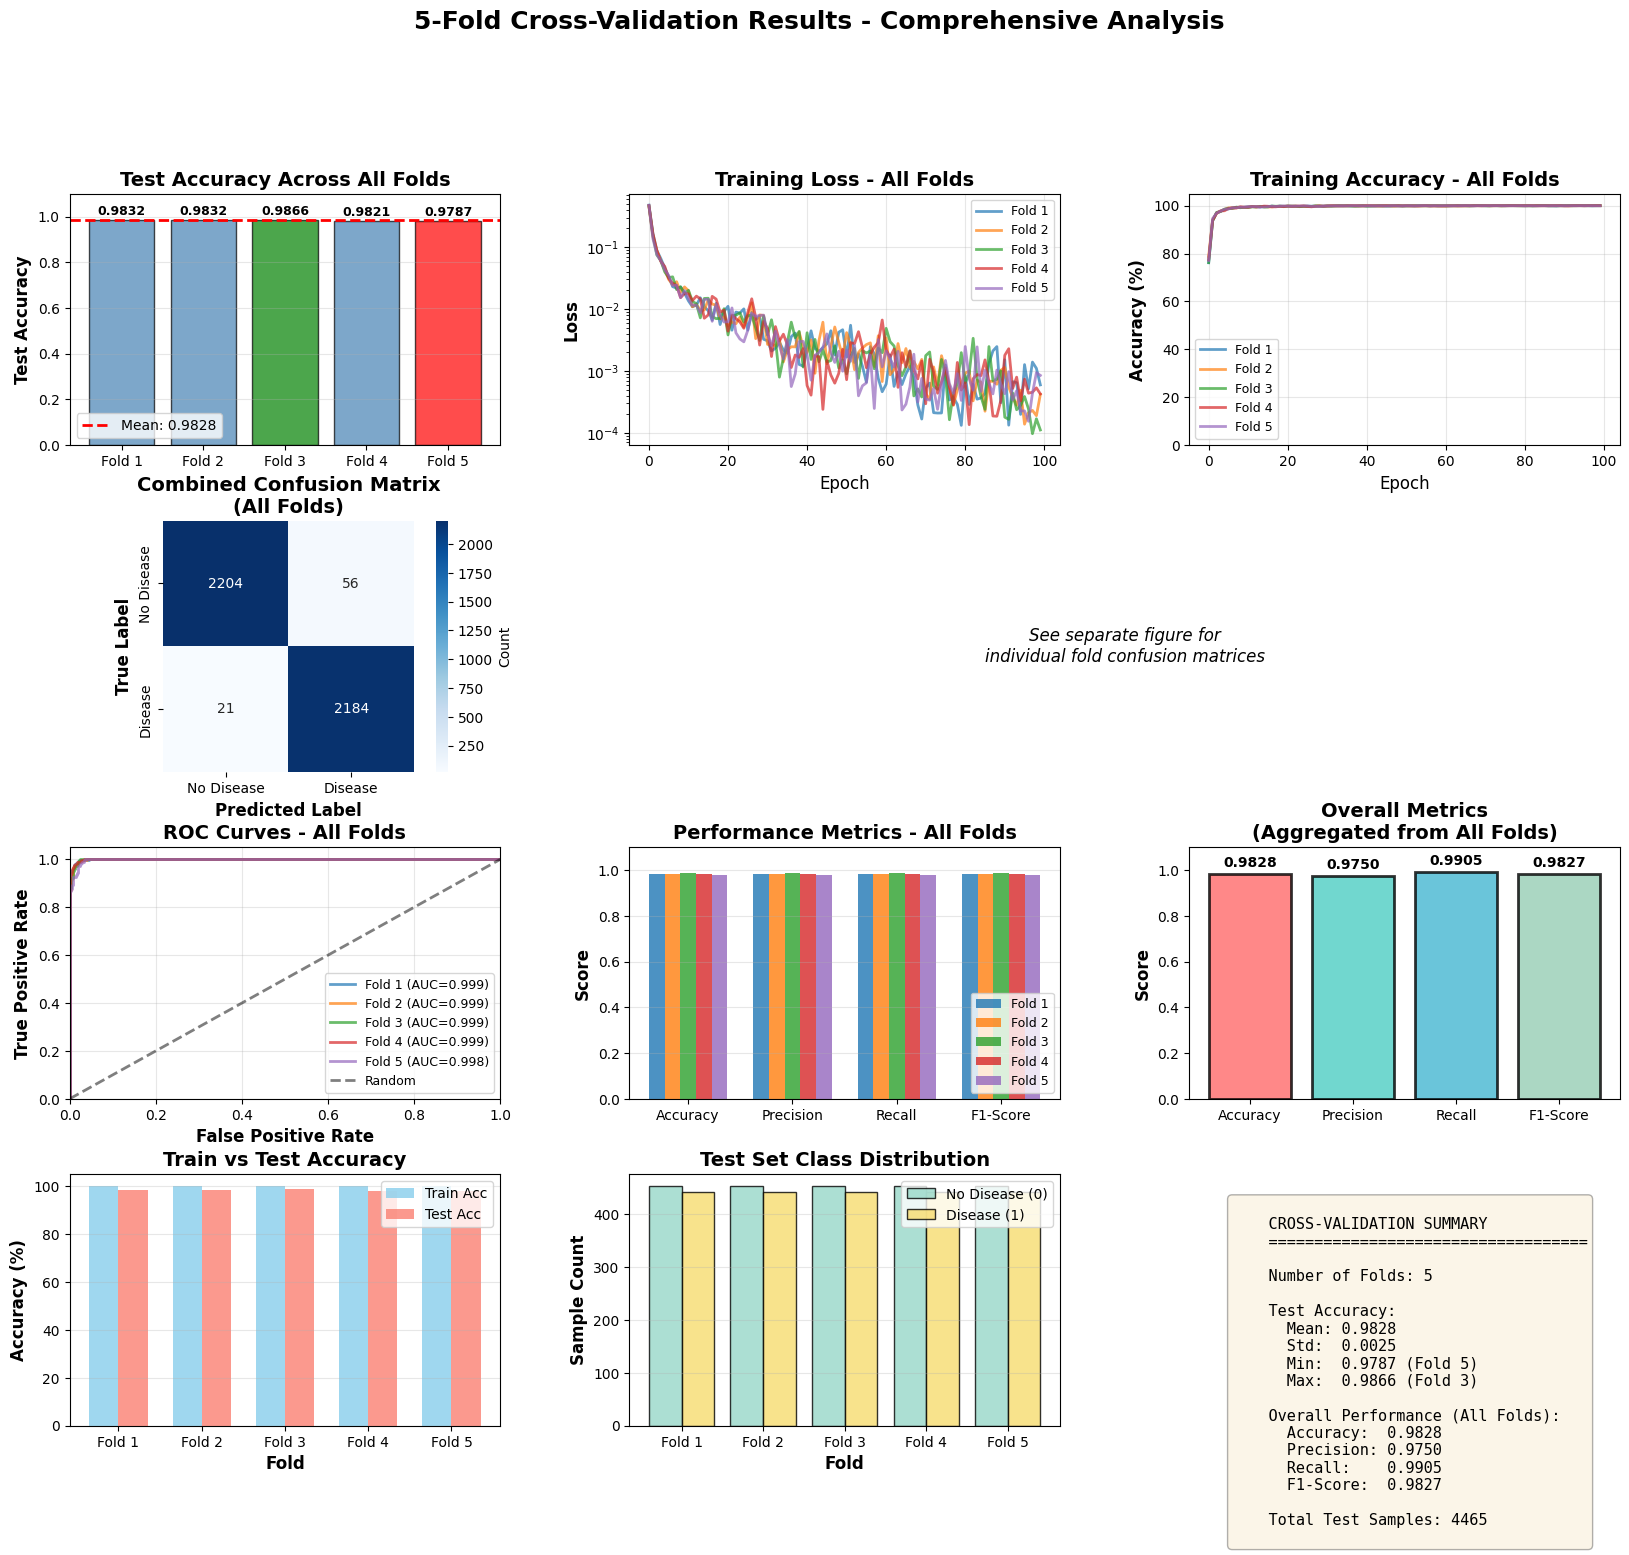

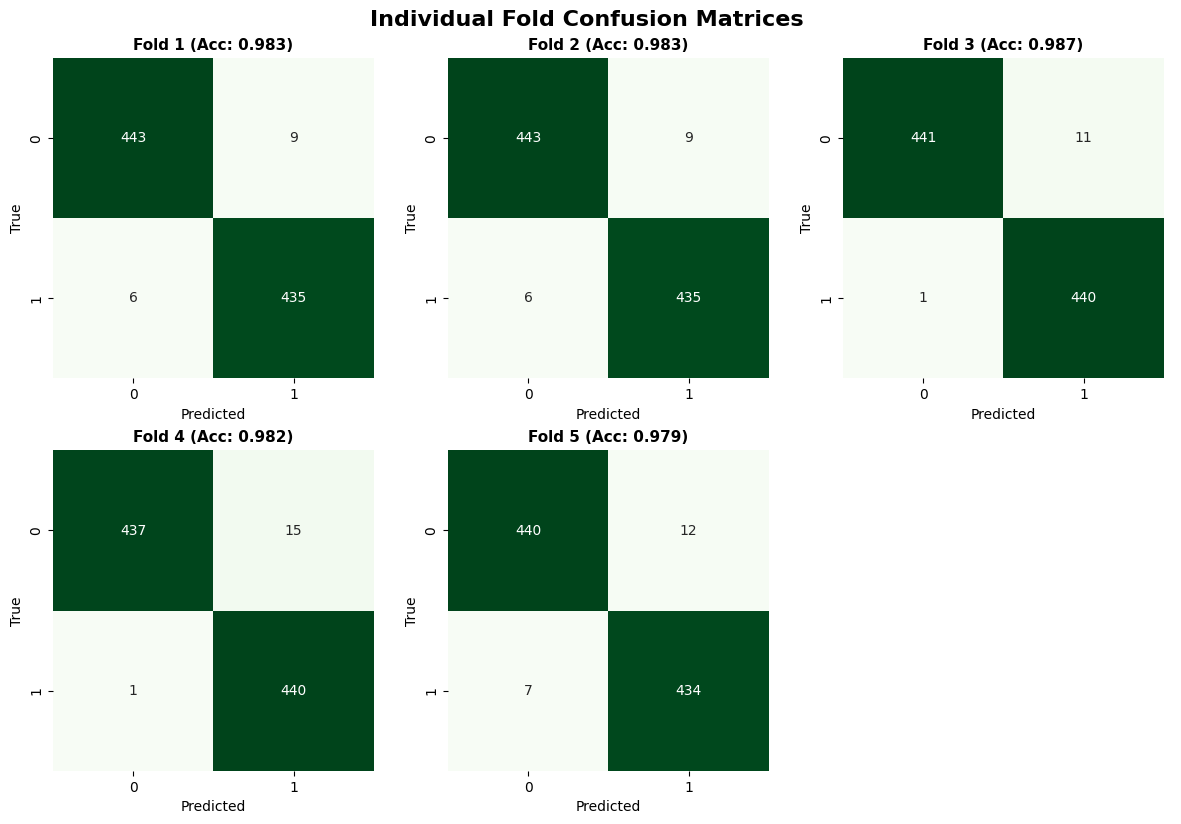


DETAILED CROSS-VALIDATION REPORT

──────────────────────────────────────────────────────────────────────
FOLD 1
──────────────────────────────────────────────────────────────────────
Test Accuracy: 0.9832
Final Training Loss: 0.000596
Final Training Accuracy: 99.97%
ROC AUC: 0.9993

Classification Report:
              precision    recall  f1-score   support

  No Disease     0.9866    0.9801    0.9834       452
     Disease     0.9797    0.9864    0.9831       441

    accuracy                         0.9832       893
   macro avg     0.9832    0.9832    0.9832       893
weighted avg     0.9832    0.9832    0.9832       893


──────────────────────────────────────────────────────────────────────
FOLD 2
──────────────────────────────────────────────────────────────────────
Test Accuracy: 0.9832
Final Training Loss: 0.000419
Final Training Accuracy: 100.00%
ROC AUC: 0.9988

Classification Report:
              precision    recall  f1-score   support

  No Disease     0.9866    0.9801  

{'fold_results': [{'fold': 1,
   'model': FeatureFusionModel(
     (numerical_mlp): NumericalMLP(
       (mlp): Sequential(
         (0): Linear(in_features=28, out_features=128, bias=True)
         (1): ReLU()
         (2): Dropout(p=0.3, inplace=False)
         (3): Linear(in_features=128, out_features=64, bias=True)
         (4): ReLU()
         (5): Dropout(p=0.3, inplace=False)
         (6): Linear(in_features=64, out_features=64, bias=True)
       )
     )
     (fusion_layer): Sequential(
       (0): Linear(in_features=128, out_features=128, bias=True)
       (1): ReLU()
       (2): Dropout(p=0.4, inplace=False)
       (3): Linear(in_features=128, out_features=64, bias=True)
       (4): ReLU()
       (5): Dropout(p=0.3, inplace=False)
     )
     (classifier): Sequential(
       (0): Linear(in_features=64, out_features=32, bias=True)
       (1): ReLU()
       (2): Dropout(p=0.2, inplace=False)
       (3): Linear(in_features=32, out_features=2, bias=True)
     )
   ),
   'test_acc

In [ ]:
visualize_all_folds(fusion_results)

### Save model weight

In [ ]:
import os
import torch

if 'fusion_results' in locals() and fusion_results is not None:
    # create a directory to save models
    save_dir = 'models/'
    os.makedirs(save_dir, exist_ok=True)

    # save weights for each fold's model
    for fold_result in fusion_results['fold_results']:
        fold_num = fold_result['fold']
        model = fold_result['model']

        # save model weights (state_dict)
        model_path = os.path.join(save_dir, f'fusion_model_fold_{fold_num}.pth')
        torch.save(model.state_dict(), model_path)
        print(f"Saved model weights for Fold {fold_num} to {model_path}")

        # optional, save scalers for preprocessing (needed for inference)
        if fold_result['num_scaler'] is not None:
            scaler_path = os.path.join(save_dir, f'num_scaler_fold_{fold_num}.pkl')
            import pickle
            with open(scaler_path, 'wb') as f:
                pickle.dump(fold_result['num_scaler'], f)
            print(f"Saved numerical scaler for Fold {fold_num} to {scaler_path}")

        if fold_result['cnn_scaler'] is not None:
            scaler_path = os.path.join(save_dir, f'cnn_scaler_fold_{fold_num}.pkl')
            with open(scaler_path, 'wb') as f:
                pickle.dump(fold_result['cnn_scaler'], f) # type: ignore
            print(f"Saved CNN scaler for Fold {fold_num} to {scaler_path}")

    # optional, save only the best fold's model (based on highest test accuracy)
    best_fold = fusion_results['best_fold']
    best_model = fusion_results['fold_results'][best_fold - 1]['model']
    best_model_path = os.path.join(save_dir, 'best_fusion_model.pth')
    torch.save(best_model.state_dict(), best_model_path)
    print(f"Saved best model weights (Fold {best_fold}) to {best_model_path}")

    print("All model weights saved successfully!")
else:
    print("fusion_results not found. Run train_fusion_model first.")

Saved model weights for Fold 1 to models/fusion_model_fold_1.pth
Saved numerical scaler for Fold 1 to models/num_scaler_fold_1.pkl
Saved CNN scaler for Fold 1 to models/cnn_scaler_fold_1.pkl
Saved model weights for Fold 2 to models/fusion_model_fold_2.pth
Saved numerical scaler for Fold 2 to models/num_scaler_fold_2.pkl
Saved CNN scaler for Fold 2 to models/cnn_scaler_fold_2.pkl
Saved model weights for Fold 3 to models/fusion_model_fold_3.pth
Saved numerical scaler for Fold 3 to models/num_scaler_fold_3.pkl
Saved CNN scaler for Fold 3 to models/cnn_scaler_fold_3.pkl
Saved model weights for Fold 4 to models/fusion_model_fold_4.pth
Saved numerical scaler for Fold 4 to models/num_scaler_fold_4.pkl
Saved CNN scaler for Fold 4 to models/cnn_scaler_fold_4.pkl
Saved model weights for Fold 5 to models/fusion_model_fold_5.pth
Saved numerical scaler for Fold 5 to models/num_scaler_fold_5.pkl
Saved CNN scaler for Fold 5 to models/cnn_scaler_fold_5.pkl
Saved best model weights (Fold 3) to models/b

# Inference

In [49]:
def extract_single_video_features(video_path, cnn_model, transform, max_frames=10):
    """
    Extract CNN features from a single video file.

    Args:
        video_path: Path to the video file
        cnn_model: Trained CNN feature extractor
        transform: Image preprocessing transform
        max_frames: Maximum number of frames to extract from video

    Returns:
        features: NumPy array of shape (1, 64) with averaged features
    """
    try:
        # Read video
        video = imageio.get_reader(str(video_path))

        # Extract frames (uniformly sampled)
        total_frames = video.count_frames()
        frame_indices = np.linspace(0, total_frames-1, min(max_frames, total_frames), dtype=int)

        frame_features = []

        for idx in frame_indices:
            frame = video.get_data(idx)

            # Convert to PIL Image and apply transform
            frame_pil = Image.fromarray(frame)
            frame_tensor = transform(frame_pil).unsqueeze(0)  # Add batch dimension

            # Move to device
            device = next(cnn_model.parameters()).device
            frame_tensor = frame_tensor.to(device)

            # Extract features
            with torch.no_grad():
                features = cnn_model(frame_tensor)

            frame_features.append(features.cpu().numpy())

        video.close()

        # Average features across frames
        avg_features = np.mean(frame_features, axis=0)

        return avg_features

    except Exception as e:
        print(f"  ✗ Error extracting features from video: {e}")
        return None

In [50]:
def preprocessing_pipeline(
    sample_index: int = 1,
    video_index: int = 0,
    num_scaler=None,
    cnn_scaler=None,
    use_saved_echonet_features=False,
    echonet_features_path='data/echonet_features.npy'
):
    """
    Preprocessing pipeline for a single patient prediction.

    Args:
        sample_index: Index of the patient sample from sulianova_data
        video_index: Index of the video from EchoNet dataset to use for CNN features
        num_scaler: Fitted numerical scaler (RobustScaler) from training
        cnn_scaler: Fitted CNN scaler (StandardScaler) from training
        use_saved_echonet_features: If True, load pre-extracted features instead of re-extracting
        echonet_features_path: Path to saved EchoNet features

    Returns:
        numerical_input: Tensor ready for model input (1, n_features)
        cnn_input: Tensor ready for model input (1, 64) or None
        label: Ground truth label (if available)
        sample_info: Dictionary with patient information
    """

    print("="*70)
    print("PREPROCESSING PIPELINE FOR SINGLE SAMPLE PREDICTION")
    print("="*70)

    # ============================================
    # STEP 1: Process Numerical Data (Cleveland/Sulianova)
    # ============================================
    print(f"\n[1/3] Processing numerical data for sample index {sample_index}...")

    # Extract single sample
    single_sample = sulianova_data.iloc[sample_index:sample_index+1].copy()

    # Preprocess and engineer features
    cleveland_X_processed, cleveland_y, _ = preprocess_and_engineer_features(single_sample)

    print(f"  ✓ Processed features shape: {cleveland_X_processed.shape}")
    print(f"  ✓ Ground truth label: {cleveland_y.values[0] if len(cleveland_y) > 0 else 'Unknown'}")

    # Apply scaler if provided (required for inference with trained model)
    if num_scaler is not None:
        cleveland_X_scaled = num_scaler.transform(cleveland_X_processed)
        print(f"  ✓ Applied numerical scaler")
    else:
        cleveland_X_scaled = cleveland_X_processed.values
        print(f"  ⚠ No scaler provided - using raw features")

    # Convert to PyTorch tensor
    numerical_input = torch.FloatTensor(cleveland_X_scaled)


    # ============================================
    # STEP 2: Process CNN Features (EchoNet)
    # ============================================
    print(f"\n[2/3] Processing CNN features for video index {video_index}...")

    cnn_input = None

    if use_saved_echonet_features and os.path.exists(echonet_features_path):
        # Load pre-extracted features
        print(f"  ✓ Loading pre-extracted EchoNet features from {echonet_features_path}...")
        echonet_features = np.load(echonet_features_path)

        if video_index < len(echonet_features):
            single_cnn_feature = echonet_features[video_index:video_index+1]
            print(f"  ✓ Extracted feature shape: {single_cnn_feature.shape}")
        else:
            print(f"  ⚠ Video index {video_index} out of range (max: {len(echonet_features)-1})")
            single_cnn_feature = None
    else:
        # Extract features from video on-the-fly
        print(f"  ✓ Extracting CNN features from EchoNet video...")

        # Load EchoNet data
        echonet_filelist, echonet_volume, videos_path = load_echonet_with_kagglehub()

        # Get specific video filename
        if video_index < len(echonet_filelist):
            video_filename = echonet_filelist.iloc[video_index]['FileName']
            video_path = videos_path / video_filename

            print(f"  ✓ Processing video: {video_filename}")

            # Extract features for this single video
            single_cnn_feature = extract_single_video_features(
                video_path, cnn_model, transform
            )

            if single_cnn_feature is not None:
                print(f"  ✓ Extracted feature shape: {single_cnn_feature.shape}")
        else:
            print(f"  ⚠ Video index {video_index} out of range")
            single_cnn_feature = None

    # Apply scaler if provided and features exist
    if single_cnn_feature is not None:
        if cnn_scaler is not None:
            single_cnn_feature_scaled = cnn_scaler.transform(single_cnn_feature)
            print(f"  ✓ Applied CNN scaler")
        else:
            single_cnn_feature_scaled = single_cnn_feature
            print(f"  ⚠ No CNN scaler provided - using raw features")

        # Convert to PyTorch tensor
        cnn_input = torch.FloatTensor(single_cnn_feature_scaled)
    else:
        print(f"  ⚠ No CNN features available - will use numerical features only")


    # ============================================
    # STEP 3: Prepare Final Inputs
    # ============================================
    print(f"\n[3/3] Preparing final inputs for model...")

    # Move to device if CUDA is available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('output device:', device)
    numerical_input = numerical_input.to(device)
    if cnn_input is not None:
        cnn_input = cnn_input.to(device)

    print(f"  ✓ Moved tensors to device: {device}")

    # Gather sample information
    sample_info = {
        'sample_index': sample_index,
        'video_index': video_index,
        'numerical_features_shape': numerical_input.shape,
        'cnn_features_shape': cnn_input.shape if cnn_input is not None else None,
        'ground_truth_label': cleveland_y.values[0] if len(cleveland_y) > 0 else None,
        'device': device
    }

    print("\n" + "="*70)
    print("PREPROCESSING COMPLETE")
    print("="*70)
    print(f"Numerical input shape: {numerical_input.shape}")
    print(f"CNN input shape: {cnn_input.shape if cnn_input is not None else 'None'}")
    print(f"Ground truth label: {sample_info['ground_truth_label']}")
    print(f"Device: {device}")

    return numerical_input, cnn_input, sample_info

In [51]:
def predict_single_sample(
    sample_index=2,
    video_index=0,
    fusion_model=None,
    num_scaler=None,
    cnn_scaler=None
):
    """
    Complete pipeline: preprocess and predict for a single sample.

    Args:
        sample_index: Index of patient in sulianova_data
        video_index: Index of video in EchoNet dataset
        fusion_model: Trained FeatureFusionModel
        num_scaler: Numerical scaler from training
        cnn_scaler: CNN scaler from training

    Returns:
        prediction: Predicted class (0 or 1)
        probability: Probability of disease (class 1)
        sample_info: Information about the sample
    """

    # Preprocess
    numerical_input, cnn_input, sample_info = preprocessing_pipeline(
        sample_index=sample_index,
        video_index=video_index,
        num_scaler=num_scaler,
        cnn_scaler=cnn_scaler,
        use_saved_echonet_features=True  # Set to False to extract on-the-fly
    )

    # Predict
    if fusion_model is not None:
        fusion_model.eval()

        with torch.no_grad():
            outputs, _ = fusion_model(numerical_input, cnn_input)
            probabilities = torch.softmax(outputs, dim=1)
            prediction = outputs.argmax(dim=1).item()
            disease_probability = probabilities[0, 1].item()

        print("\n" + "="*70)
        print("PREDICTION RESULTS")
        print("="*70)
        print(f"Predicted class: {prediction} ({'Disease' if prediction == 1 else 'No Disease'})")
        print(f"Disease probability: {disease_probability:.4f}")
        print(f"Ground truth: {sample_info['ground_truth_label']} ({'Disease' if sample_info['ground_truth_label'] == 1 else 'No Disease'})")

        return prediction, disease_probability, sample_info
    else:
        print("⚠ No model provided - returning preprocessed inputs only")
        return None, None, sample_info

### Loading Models Weight 

In [52]:
# Recreate the model architecture (must match the original)
fusion_model = create_fusion_model(numerical_dim=28)  # Use the same numerical_dim as in training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load weights
model_path = 'models/best_fusion_model.pth'  # Or any fold-specific path
fusion_model.load_state_dict(torch.load(model_path))
fusion_model.to(device) # to 'cuda'
fusion_model.eval()  # Set to evaluation mode

# Load scalers
import pickle
with open('models/num_scaler_fold_1.pkl', 'rb') as f:
    num_scaler = pickle.load(f)
with open('models/cnn_scaler_fold_1.pkl', 'rb') as f:
    cnn_scaler = pickle.load(f)

In [53]:
# Ensure the fusion model is on the correct device (CUDA if available)
fusion_model.eval()

FeatureFusionModel(
  (numerical_mlp): NumericalMLP(
    (mlp): Sequential(
      (0): Linear(in_features=28, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.3, inplace=False)
      (6): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (fusion_layer): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=2, bias=True)
  )
)

### Prediction

In [57]:
# Predict for patient 2 with video 0
prediction, probability, info = predict_single_sample(
    sample_index=3,
    video_index=1,
    fusion_model=fusion_model,
    num_scaler=num_scaler,
    cnn_scaler=cnn_scaler,
)

PREPROCESSING PIPELINE FOR SINGLE SAMPLE PREDICTION

[1/3] Processing numerical data for sample index 3...
Final feature shape: (1, 28)
  ✓ Processed features shape: (1, 28)
  ✓ Ground truth label: 1
  ✓ Applied numerical scaler

[2/3] Processing CNN features for video index 1...
  ✓ Loading pre-extracted EchoNet features from data/echonet_features.npy...
  ✓ Extracted feature shape: (1, 64)
  ✓ Applied CNN scaler

[3/3] Preparing final inputs for model...
output device: cuda
  ✓ Moved tensors to device: cuda

PREPROCESSING COMPLETE
Numerical input shape: torch.Size([1, 28])
CNN input shape: torch.Size([1, 64])
Ground truth label: 1
Device: cuda

PREDICTION RESULTS
Predicted class: 0 (No Disease)
Disease probability: 0.0000
Ground truth: 1 (No Disease)


c:\Users\APC\miniconda3\envs\new\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
